In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')       

In [3]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#import datetime as dt
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.shape

(541909, 8)

In [7]:
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]

In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]

In [10]:
df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [15]:
df['CustomerID'].nunique()

4339

In [17]:
from lifetimes.plotting import *
from lifetimes.utils import *


In [18]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')

In [20]:
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


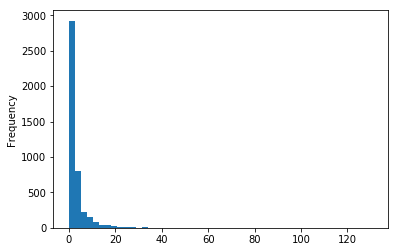

In [24]:
data['frequency'].plot(kind='hist', bins=50)


In [25]:
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


In [43]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.00)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


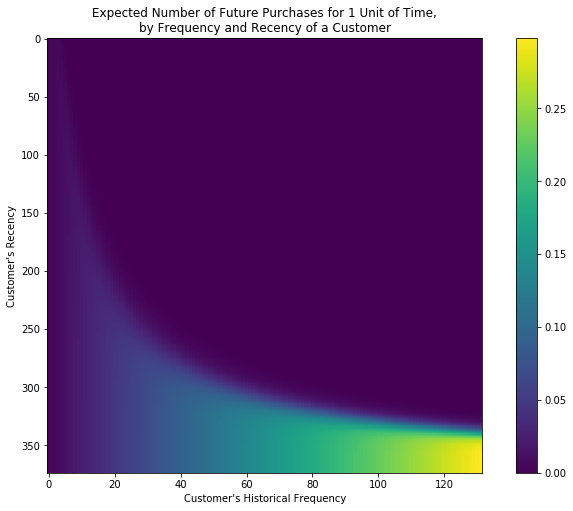

In [44]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

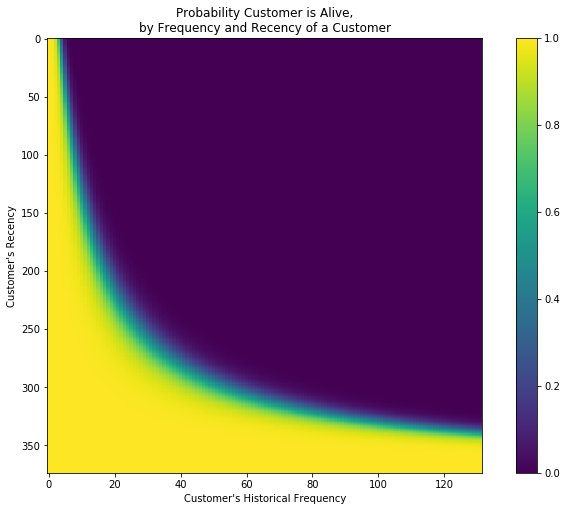

In [45]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [46]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


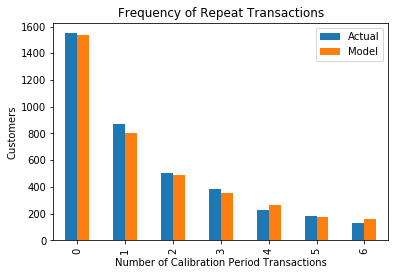

In [47]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [48]:
from lifetimes.utils import calibration_and_holdout_data

In [49]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  184  
12347.0                  184  
12348.0                  184  
12350.0                  184  
12352.0                  184  


In [63]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15655772116706926

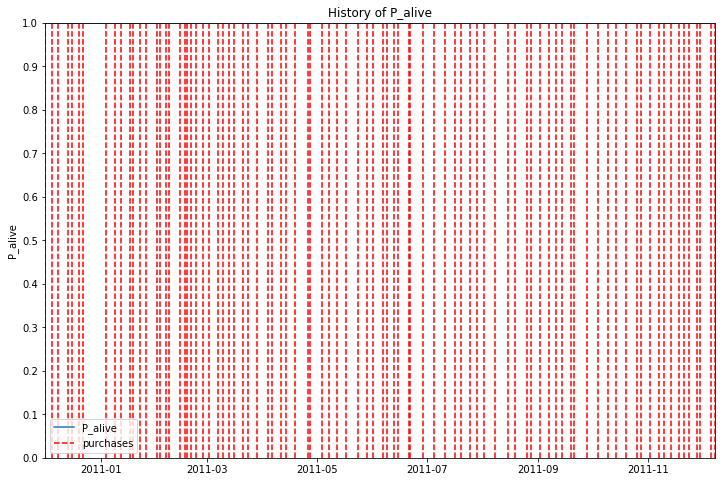

In [60]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

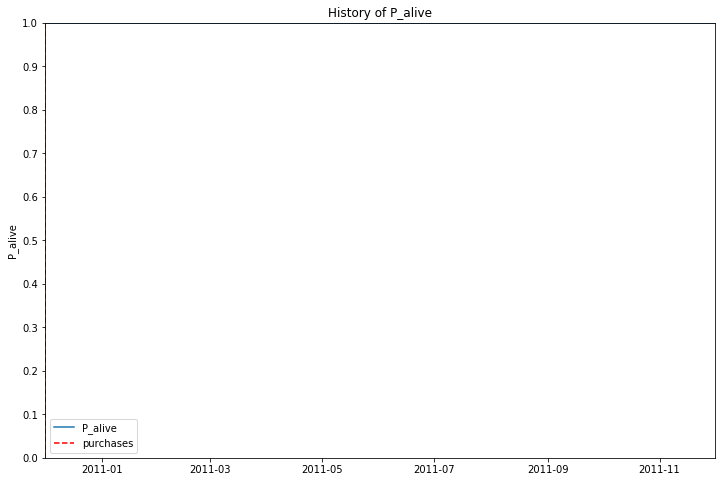

In [64]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')